In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from helper_functions.utils import *
from helper_functions.preprocessing import replace_black_with_median

class DynamicCAPTCHASegmenter:
    def __init__(self, min_char_width=5, max_char_width=100, max_aspect_ratio=2.0):
        self.min_char_width = min_char_width
        self.max_char_width = max_char_width
        self.max_aspect_ratio = max_aspect_ratio
        
    def get_captcha_length(self, filename):
        """Extract length from filename (e.g., 'ABC12-12345.png' -> 5)"""
        filename_without_suffix = os.path.splitext(filename)[0]
        correct_characters = filename_without_suffix.split('-')[0]
        return len(correct_characters) - 22
    
    def preprocess_image(self, gray_img):
        """Enhanced preprocessing pipeline"""
        # Contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray_img)
        
        # Adaptive thresholding with automatic block size
        img_height, img_width = gray_img.shape
        block_size = max(3, min(img_width, img_height) // 10 | 1)  # Ensure odd number
        thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, block_size, 2)
        
        # Remove small noise
        kernel = np.ones((2,2), np.uint8)
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        return cleaned
    
    def segment_by_contours(self, thresh_img):
        """Primary segmentation using contours"""
        contours, _ = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours by size and aspect ratio
        filtered = []
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = float(w)/h
            
            if (self.min_char_width <= w <= self.max_char_width and
                aspect_ratio <= self.max_aspect_ratio):
                filtered.append((x, y, w, h))
        
        # Sort left to right
        filtered.sort(key=lambda item: item[0])
        return filtered
    
    def segment_by_projection(self, thresh_img):
        """Fallback segmentation using vertical projections"""
        # Sum pixels vertically
        vertical_proj = np.sum(thresh_img, axis=0)
        
        # Find character boundaries
        in_char = False
        boundaries = []
        start = 0
        
        for i, val in enumerate(vertical_proj):
            if val > 0 and not in_char:
                in_char = True
                start = i
            elif val == 0 and in_char:
                in_char = False
                end = i
                width = end - start
                if self.min_char_width <= width <= self.max_char_width:
                    boundaries.append((start, end))
        
        # Convert to same format as contour segments (x,y,w,h)
        segments = []
        img_height = thresh_img.shape[0]
        for start, end in boundaries:
            segments.append((start, 0, end-start, img_height))
        
        return segments
    
    def merge_close_segments(self, segments, threshold=5):
        """Merge segments that are very close together"""
        if not segments:
            return segments
            
        merged = [segments[0]]
        for current in segments[1:]:
            last = merged[-1]
            # If current segment starts close to where last segment ended
            if current[0] - (last[0] + last[2]) < threshold:
                # Merge them
                new_x = last[0]
                new_w = (current[0] + current[2]) - last[0]
                new_y = min(last[1], current[1])
                new_h = max(last[1]+last[3], current[1]+current[3]) - new_y
                merged[-1] = (new_x, new_y, new_w, new_h)
            else:
                merged.append(current)
        return merged
    
    def extract_characters(self, segments, gray_img, output_size=(28, 28)):
        """Extract and normalize character images"""
        chars = []
        
        for x, y, w, h in segments:
            # Extract character region
            char_region = gray_img[y:y+h, x:x+w]
            
            # Local thresholding
            _, char_thresh = cv2.threshold(char_region, 0, 255, 
                                        cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            
            # Center character in square canvas
            size = max(w, h) + 4  # Small padding
            canvas = np.zeros((size, size), dtype=np.uint8)
            
            # Calculate position to center the character
            x_offset = (size - w) // 2
            y_offset = (size - h) // 2
            
            canvas[y_offset:y_offset+h, x_offset:x_offset+w] = char_thresh
            
            # Resize to output size
            resized = cv2.resize(canvas, output_size)
            chars.append(resized)
        
        return chars
    
    def process_image(self, img, filename=None):
        """Complete processing pipeline with fallback logic"""
        # Get expected length if filename is provided
        expected_length = self.get_captcha_length(filename) if filename else None
        print("expected length:" + str(expected_length))
        
        # Convert to grayscale (using your preprocessed image)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Thresholding
        thresh_img = self.preprocess_image(gray_img)
        
        # First try: contour segmentation
        contour_segments = self.segment_by_contours(thresh_img)
        
        # Check if we got the right number of characters
        if expected_length is not None and len(contour_segments) != expected_length:
            print("fallback to projection")
            segments = self.segment_by_projection(thresh_img)
            # Fallback to projection method
        #     projection_segments = self.segment_by_projection(thresh_img)
        #     projection_segments = self.merge_close_segments(projection_segments)
            
        #     # Use whichever method got closer to expected length
        #     contour_diff = abs(len(contour_segments) - expected_length)
        #     proj_diff = abs(len(projection_segments) - expected_length)
            
        #     if proj_diff < contour_diff:
        #         segments = projection_segments
        #     else:
        #         segments = contour_segments
        else:
            segments = contour_segments
        
        # Final check and adjustment
        if expected_length is not None and len(segments) != expected_length:
            # Try to split the largest segments if we're under
            if len(segments) < expected_length:
                segments.sort(key=lambda s: s[2], reverse=True)  # Sort by width
                for i in range(expected_length - len(segments)):
                    if i < len(segments):
                        x, y, w, h = segments[i]
                        if w > self.min_char_width * 2:
                            segments[i] = (x, y, w//2, h)
                            segments.insert(i+1, (x+w//2, y, w-w//2, h))
            
            # Or merge the smallest segments if we're over
            elif len(segments) > expected_length:
                segments.sort(key=lambda s: s[2])  # Sort by width
                while len(segments) > expected_length and len(segments) > 1:
                    # Merge two smallest segments
                    seg1 = segments.pop(0)
                    seg2 = segments.pop(0)
                    new_x = min(seg1[0], seg2[0])
                    new_w = max(seg1[0]+seg1[2], seg2[0]+seg2[2]) - new_x
                    new_y = min(seg1[1], seg2[1])
                    new_h = max(seg1[1]+seg1[3], seg2[1]+seg2[3]) - new_y
                    segments.append((new_x, new_y, new_w, new_h))
                    segments.sort(key=lambda s: s[0])  # Re-sort by x-position
        
        # Character extraction
        char_images = self.extract_characters(segments, gray_img)
        
        return char_images
    
    def visualize_results(self, original_img, char_images, filename=None):
        """Visualize original image and segmented characters"""
        plt.figure(figsize=(12, 6))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        title = 'Original CAPTCHA'
        if filename:
            title += f' ({filename})'
        plt.title(title)
        plt.axis('off')
        
        # Segmented characters
        plt.subplot(1, 2, 2)
        if char_images:
            # Add small spacing between characters
            spacer = np.ones((char_images[0].shape[0], 5), dtype=np.uint8) * 255
            combined = np.hstack([img for pair in zip(char_images, [spacer]*len(char_images)) 
                              for img in pair][:-1])
            plt.imshow(combined, cmap='gray', vmin=0, vmax=255)
            plt.title(f'Segmented Characters ({len(char_images)} found)')
        else:
            plt.title('No characters found')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()


expected length:7
fallback to projection


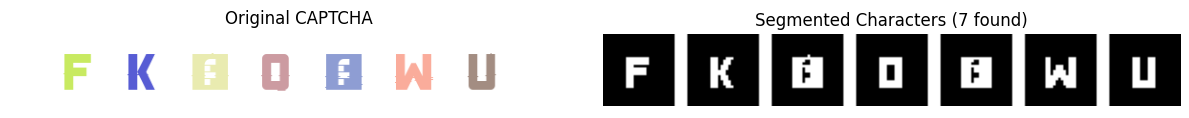

expected length:6


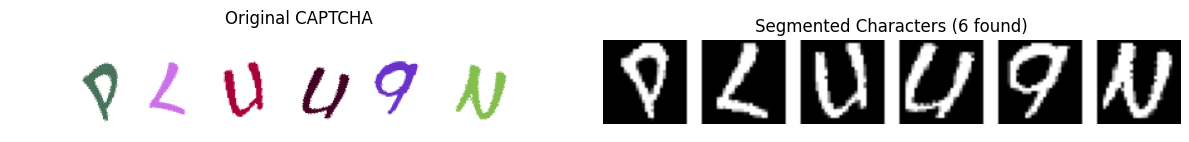

expected length:4


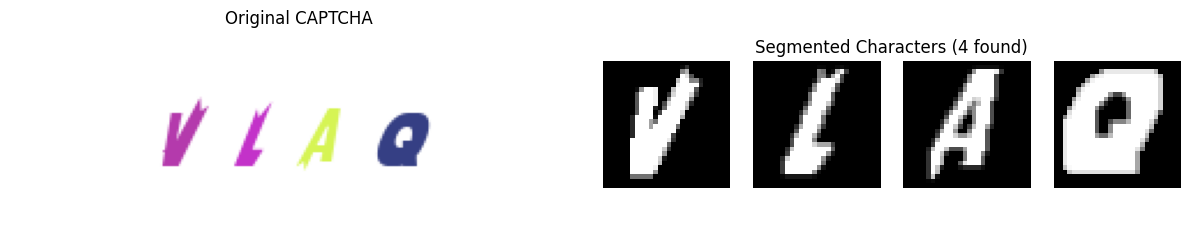

expected length:8
fallback to projection


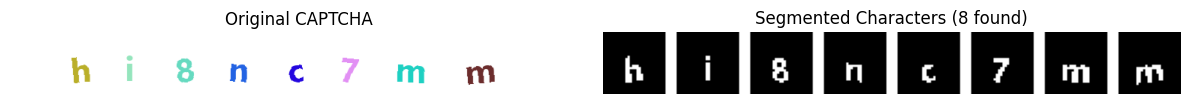

expected length:6


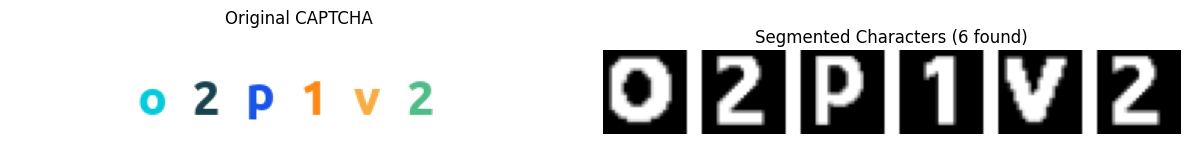

expected length:6


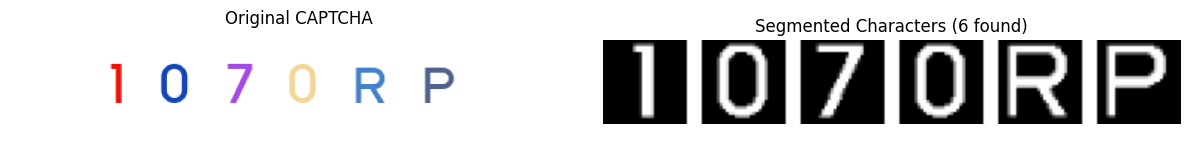

expected length:6
fallback to projection


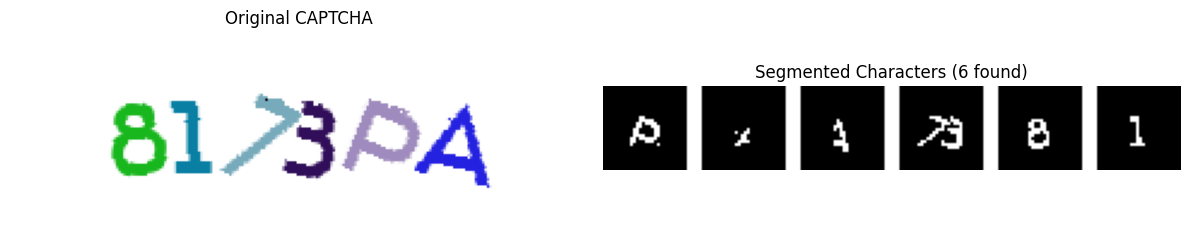

expected length:4


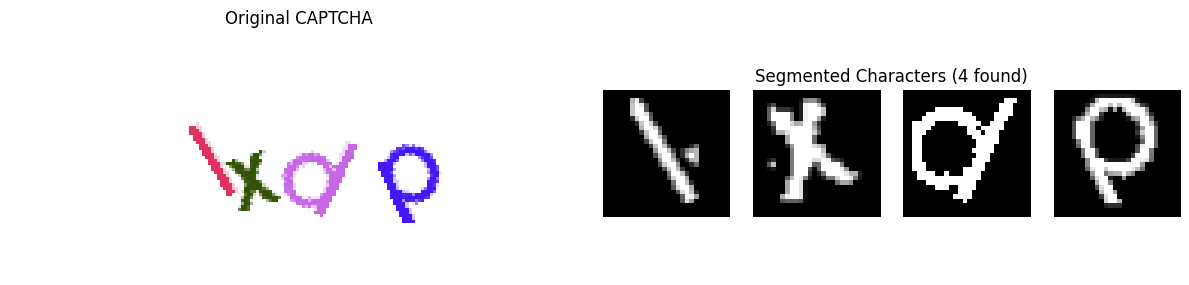

expected length:6
fallback to projection


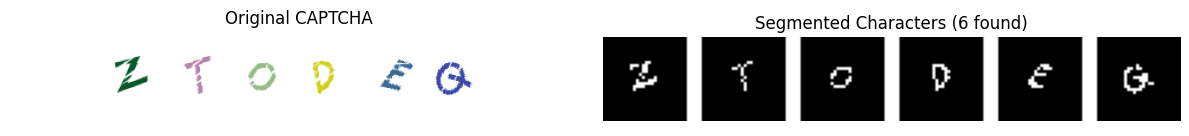

expected length:6
fallback to projection


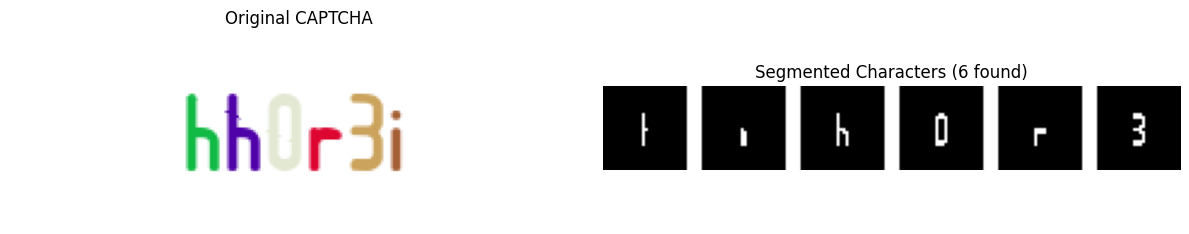

In [3]:
segmenter = DynamicCAPTCHASegmenter()

TRAIN_IMGS_DIR = "../data/train/combine"
NUM_IMGS = 10
# imgs = get_n_random_train_imgs_with_fname(TRAIN_IMGS_DIR, NUM_IMGS)
# denoised_imgs = [replace_black_with_median(img.copy()) for img in imgs]
def get_n_random_train_img_with_fname(train_imgs_dir, n):
    filepaths = random.choices(get_png_filepaths(train_imgs_dir), k=n)
    return [[cv2.imread(filepath), filepath] for filepath in filepaths]

for img, filename in get_n_random_train_img_with_fname(TRAIN_IMGS_DIR, NUM_IMGS):
    denoised_imgs = replace_black_with_median(img.copy())
    char_images = segmenter.process_image(denoised_imgs, filename)
    segmenter.visualize_results(denoised_imgs, char_images)